# **EDA**
## Imports

In [23]:
# Standard library imports
from re import sub
import numpy as np
import random

# Third-party libraries
from contractions import fix
import nltk
from pandas import DataFrame, read_csv, Series
from joblib import dump, load
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import nlpaug.augmenter.word as naw
from os import makedirs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# NLTK downloads
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

In [24]:
# Regular hyperparameters
lemmatize = True
stop_words = set(stopwords.words('english'))
max_features = 10000

# Fine-tuning hyperparameters
combine_fields = ['from', 'director', 'title']
threshold = 0.00

## Load data

In [25]:
def load_data(filepath):
    data = pd.read_csv(filepath, sep='\t', names=['title', 'from', 'genre', 'director', 'plot'])
    return data

In [26]:
data = load_data('train.txt')
data.head()

,title,from,genre,director,plot
0,Ela Cheppanu,Telugu,romance,Ramana,Sekhar (Tarun) is a graduate from IIM and work...
1,A Nightmare on Elm Street,American,horror,Samuel Bayer,Kris Fowles (Katie Cassidy) goes to the Spring...
2,American Gothic,American,horror,John Hough,Cynthia is traumatized by the death of her bab...
3,Gang,Bollywood,crime,Mazhar Khan,"Four friends, Gangu (Jackie Shroff), Abdul (Na..."
4,Intimate Relations,British,drama,Charles Frank,Crisis in a middle-class family when the son f...


In [27]:
# Combine fields
def combine():
    # Extract relevant columns (plot, combine_fields, genre)
    selected_fields = ['plot'] + combine_fields
    if 'genre' in data.columns:
        selected_fields.append('genre')
    combined_data = data[selected_fields].copy()

    # Handle missing values: drop rows with missing 'plot', fill missing combine_fields with ''
    combined_data.dropna(subset=['plot'], inplace=True)  # Ensure 'plot' is not NaN
    for field in combine_fields:
        combined_data[field] = combined_data[field].fillna('')  # Replace NaN in combine_fields with empty strings

    # Combine plot and other specified fields into a single feature
    combined_data['combined_text'] = combined_data['plot']
    for field in combine_fields:
        combined_data['combined_text'] += ' ' + combined_data[field]

    return combined_data

In [28]:
data = combine()
data.head()

,plot,from,director,title,genre,combined_text
0,Sekhar (Tarun) is a graduate from IIM and work...,Telugu,Ramana,Ela Cheppanu,romance,Sekhar (Tarun) is a graduate from IIM and work...
1,Kris Fowles (Katie Cassidy) goes to the Spring...,American,Samuel Bayer,A Nightmare on Elm Street,horror,Kris Fowles (Katie Cassidy) goes to the Spring...
2,Cynthia is traumatized by the death of her bab...,American,John Hough,American Gothic,horror,Cynthia is traumatized by the death of her bab...
3,"Four friends, Gangu (Jackie Shroff), Abdul (Na...",Bollywood,Mazhar Khan,Gang,crime,"Four friends, Gangu (Jackie Shroff), Abdul (Na..."
4,Crisis in a middle-class family when the son f...,British,Charles Frank,Intimate Relations,drama,Crisis in a middle-class family when the son f...


In [29]:
# Split data into training and test sets
def split_data():
    X = data['combined_text']  # Assuming 'combined_text' is your features (plots)
    y = data['genre']          # Assuming 'genre' is your target variable
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Perform train/test split while returning the indices of the test set
    X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
        X, y_encoded, data.index, test_size=0.1, random_state=42, stratify=y_encoded
    )

    return X_train, X_test, y_train, y_test, label_encoder, test_indices

In [30]:
X_train, X_test, y_train, y_test, label_encoder,test_indices = split_data()
label_encoder.classes_

array(['action', 'animation', 'comedy', 'crime', 'drama', 'horror',
       'romance', 'sci-fi', 'western'], dtype=object)

In [31]:
data = DataFrame({'combined_text': X_train, 'genre': y_train})

# Initialize the seed
random.seed(42)

# Initialize the SynonymAugmenter
aug = naw.SynonymAug(aug_src='wordnet', aug_max=30)
augments_encoded = label_encoder.transform(['sci-fi', 'animation', 'crime'])

# Define augmentation settings for each genre
augmentation_config = {
    augments_encoded[0]: 3,    # Augment 3 times
    augments_encoded[1]: 1, # Augment 1 time
    augments_encoded[2]: 1,     # Augment 1 time
}

# Not augmenting the remaining genre
for genre in np.unique(y_train):
    if genre not in augmentation_config:
        augmentation_config[genre] = 0  # Default to augmenting once

# List to hold original and augmented text along with their genres
all_texts = []
all_genres = []

# Loop through each genre and apply the augmentation as needed
for genre, n in augmentation_config.items():
    genre_data = data[data['genre'] == genre].copy()

    # Add original texts and genres to the lists
    all_texts.extend(genre_data['combined_text'].tolist())
    all_genres.extend([genre] * len(genre_data))  # Repeat the genre for the number of rows

    # Apply augmentation if n > 0
    if n > 0:
        augmented_texts = genre_data['combined_text'].apply(lambda x: aug.augment(x, n=n))
        # Flatten the lists of augmented texts
        augmented_texts = augmented_texts.explode().tolist()
        # Add augmented texts and genres to the lists
        all_texts.extend(augmented_texts)
        all_genres.extend([genre] * len(augmented_texts))  # Repeat the genre for the number of augmented rows

# Create a DataFrame with the text and genre columns
data = DataFrame({'text': all_texts, 'genre': all_genres})

data.head()

,text,genre
0,"In the near future,[3] Lunar Industries has ma...",7
1,"The plot follows a disgruntled scientist who, ...",7
2,"Set inside a Quake like video game, one of the...",7
3,Dr. Maxwell Kirshner (Ray Milland) arrives at ...,7
4,"On November 5, 1975 in Snowflake, Arizona, log...",7


# Pre-processing

In [32]:
# Clean the text
def clean_text(text):
    # Check if the text is a non-empty string
    if not isinstance(text, str) or not text.strip():
        return ''

    # Skip applying contractions if the text is too long or complex
    if len(text) > 500:  # Threshold to skip contraction expansion for long texts
        return text

    # Try expanding contractions safely
    try:
        text = fix(text)
    except Exception as e:
        print(f"Error expanding contractions: {e}, for text: {text[:100]}...")  # Only print the first 100 characters
        return text  # Return the original text if expansion fails

    # Remove special characters and digits
    text = sub(r'[^a-zA-Z\s]', '', text)

    return text

# Function to convert nltk POS tag to wordnet POS tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return wordnet.NOUN  # Default to noun


# Function to lemmatize text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    # Tokenize the text
    tokens = nltk.word_tokenize(text.lower())
    # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]
    # Perform POS tagging
    tagged_tokens = nltk.pos_tag(tokens)
    # Lemmatize each token using the POS tag
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_tokens]
    return ' '.join(lemmatized_tokens)

# Preprocess the data without stop words
def preprocess_data(df):
    # Clean the text
    df['text'] = df['text'].apply(clean_text)
    # Apply lemmatization if specified
    if lemmatize:
        df['text'] = df['text'].apply(lemmatize_text)

    return df

In [33]:
# Preprocess test data
data_test = DataFrame({'text': X_test})
X_test = preprocess_data(data_test)['text']
y_train = data['genre']

In [34]:
# Genre words to remove from the data
genres = ['horror', 'crime', 'action', 'comedy', 'animation', 'western']

In [35]:
X_train = data['text']
X_train_series = Series(X_train)

# CountVectorizer to create a document-term matrix for stop words
vectorizer = CountVectorizer(vocabulary=stop_words, binary=True)  # Count presence
X = vectorizer.fit_transform(X_train_series)  # Transform the title-plot feature

# Compute document frequencies
doc_freq = X.sum(axis=0) / X.shape[0]  # Fraction of documents (observations) containing each stop word

# Sort stop words by document frequency.
stop_word_df = DataFrame({
    'stop_word': vectorizer.get_feature_names_out(),
    'doc_frequency': doc_freq.A1
}).sort_values(by='doc_frequency', ascending=False)

# Set a threshold for significant stop words
def threshold_stop_word_df():
  return stop_word_df[stop_word_df['doc_frequency'] >= threshold]

stop_words_filtered = threshold_stop_word_df()['stop_word'].tolist()
stop_words_filtered += genres

## Basic statistics

In [36]:
genre_summary = y_train.describe() # count, mean, std, ...

# Length analysis (counting words)
data['word_count'] = X_train.apply(lambda x: len(x.split()))
title_plot_summary = data['word_count'].describe()

# Genre distribution
genre_counts = data['genre'].value_counts()


print(f'''\n{'-'*60}
Genre Summary Statistics :\n{genre_summary}\n{'-'*60}
Word Count (Title-Plot Combined Feature) Summary : \n{title_plot_summary}\n{'-'*60}
Word Count Distribution by Genre: per genre :\n{genre_counts}
''')


------------------------------------------------------------
Genre Summary Statistics :
count    8783.000000
mean        3.780371
std         2.429168
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max         8.000000
Name: genre, dtype: float64
------------------------------------------------------------
Word Count (Title-Plot Combined Feature) Summary : 
count    8783.000000
mean      391.215075
std       318.984827
min         9.000000
25%       123.000000
50%       314.000000
75%       619.000000
max      3251.000000
Name: word_count, dtype: float64
------------------------------------------------------------
Word Count Distribution by Genre: per genre :
genre
4    1508
2    1074
5     997
3     974
1     962
0     953
6     797
7     772
8     746
Name: count, dtype: int64



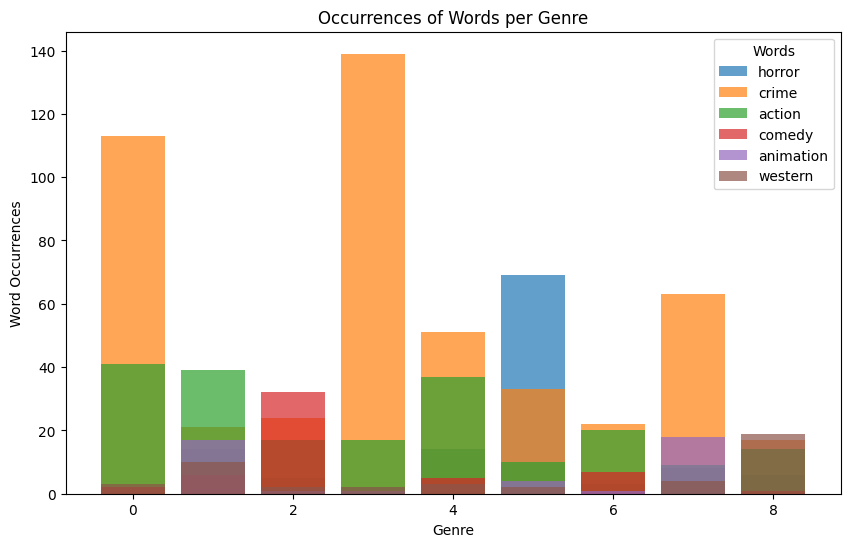

In [38]:
# Count occurrences of each word per row and create new columns for each word
for genre in genres:
    data[f'{genre}_count'] = X_train.apply(lambda x: x.split().count(genre))

# Group by genre and sum the occurrences of each word
word_count_per_genre = data.groupby('genre')[[f'{word}_count' for word in genres]].sum().reset_index()

# Plotting occurrences of each word per genre
plt.figure(figsize=(10, 6))
for word in genres:
    plt.bar(word_count_per_genre['genre'], word_count_per_genre[f'{word}_count'], label=f'{word}', alpha=0.7)

plt.xlabel('Genre')
plt.ylabel('Word Occurrences')
plt.title(f'Occurrences of Words per Genre')
plt.legend(title='Words')
plt.xticks(rotation=0)
plt.show()

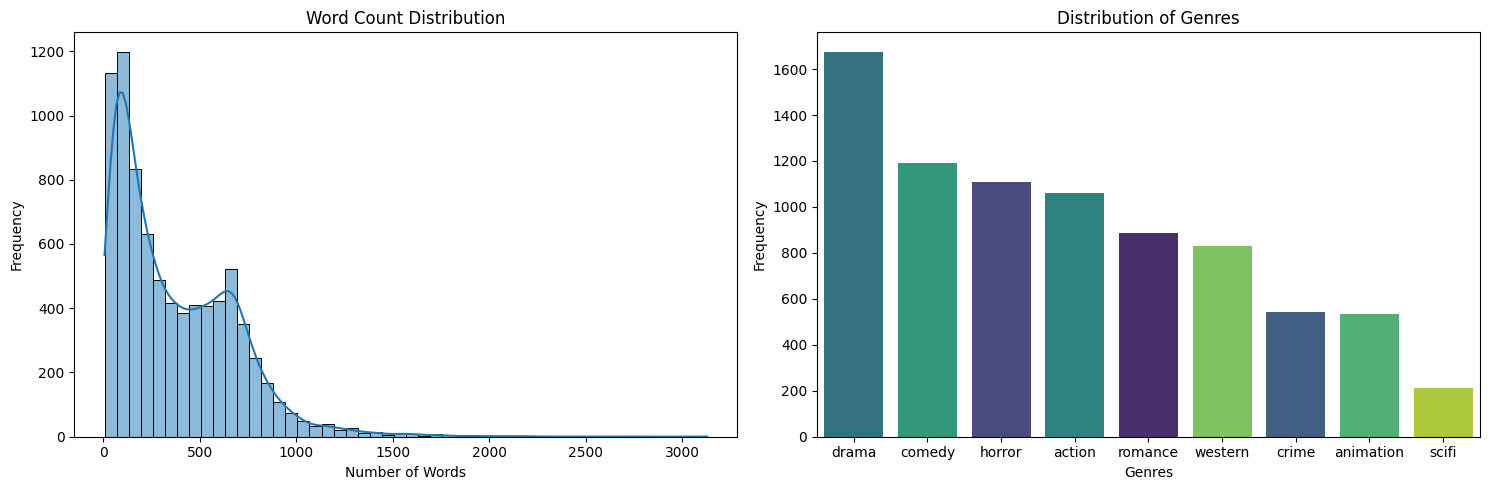

In [ ]:
# Plotting the word count and genre destributions
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Word count distribution
    sns.histplot(data['word_count'], bins=50, ax=axes[0], kde=True)
    axes[0].set_title('Word Count Distribution')
    axes[0].set_xlabel('Number of Words')
    axes[0].set_ylabel('Frequency')

    # Distribution of the target variable (genre)
    sns.countplot(x='genre', data=data, hue='genre', palette='viridis', order=data['genre'].value_counts().index, legend=False)
    axes[1].set_title('Distribution of Genres')
    axes[1].set_xlabel('Genres')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

## Stop Words Processing: Analysis and Removal




In [ ]:
# CountVectorizer to create a document-term matrix for stop words
stop_words = set(stopwords.words('english'))  # English stop words
vectorizer = CountVectorizer(vocabulary=stop_words, binary=True)  # Count presence
X = vectorizer.fit_transform(data['title_plot'])  # Transform the title-plot feature

# Compute document frequencies
doc_freq = X.sum(axis=0) / X.shape[0]  # Fraction of documents (observations) containing each stop word

# Sort stop words by document frequency.
stop_word_df = pd.DataFrame({
    'stop_word': vectorizer.get_feature_names_out(),
    'doc_frequency': doc_freq.A1
}).sort_values(by='doc_frequency', ascending=False)

# Set a threshold for significant stop words
def threshold_stop_word_df(stop_word_df, threshold=0.82):   # Appearing in 80% of observations
  return stop_word_df[stop_word_df['doc_frequency'] >= threshold]

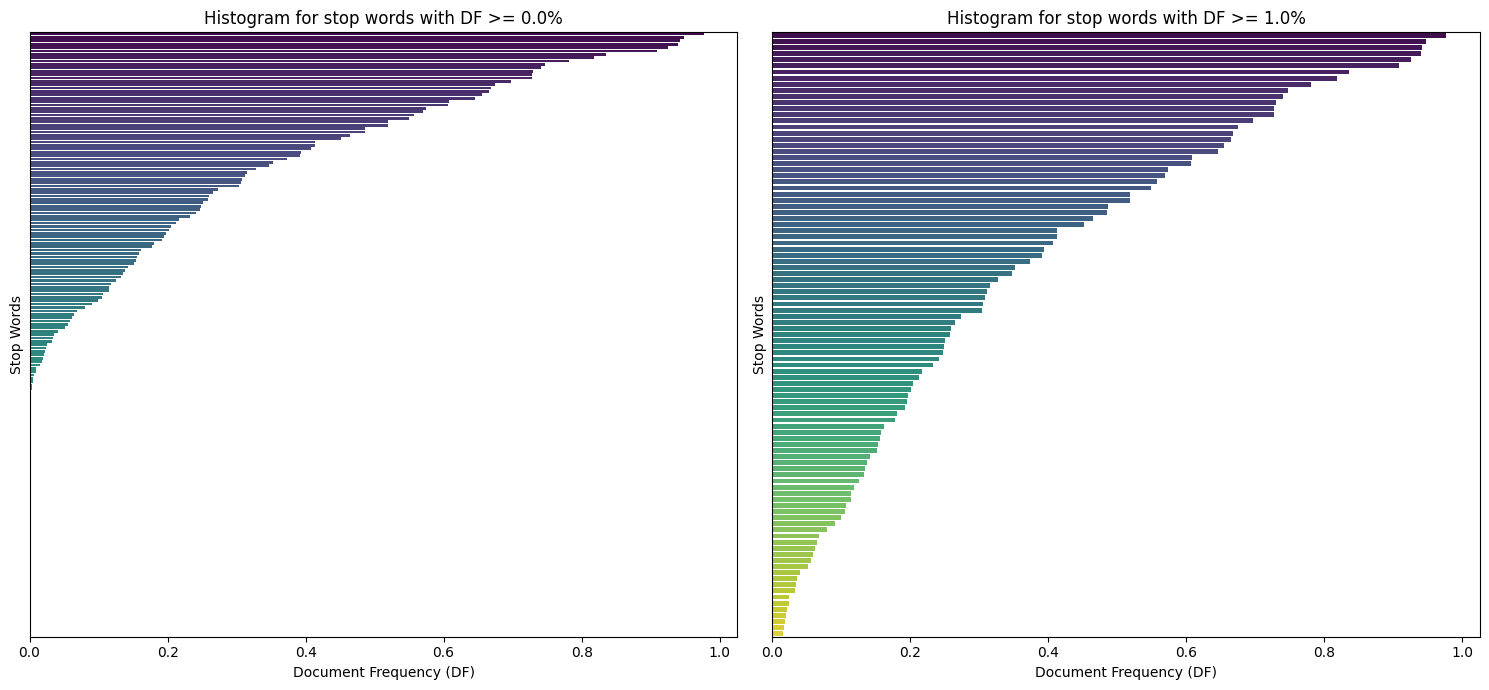

In [ ]:
# Stop words document frequency (DF)
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    plt.figure(figsize=(15, 7))

    # Stop words appearing in >= 0 observations
    threshold = 0.0
    plt.subplot(1, 2, 1)
    sns.barplot(x='doc_frequency', y='stop_word', data=threshold_stop_word_df(stop_word_df, threshold), palette='viridis')
    plt.title(f'Histogram for stop words with DF >= {threshold*100}%')
    plt.xlabel('Document Frequency (DF)')
    plt.ylabel('Stop Words')
    plt.yticks([])

    # Stop words appearing in >= 1% observations
    threshold = 0.01
    top_stop_words = stop_word_df[stop_word_df['doc_frequency'] >= threshold]
    plt.subplot(1, 2, 2)
    sns.barplot(x='doc_frequency', y='stop_word', data=threshold_stop_word_df(stop_word_df, threshold), palette='viridis')
    plt.title(f'Histogram for stop words with DF >= {threshold*100}%')
    plt.xlabel('Document Frequency (DF)')
    plt.ylabel('Stop Words')
    plt.yticks([])

    plt.tight_layout()
    plt.show()

In [ ]:
threshold = 0.5   # choose stop word' DF threshold
stop_words = threshold_stop_word_df(stop_word_df, threshold)['stop_word'].tolist()
threshold = int(threshold*100)

# Save the stop words to a file
file = open(f'stop_words{threshold}.txt','w')
for stop_word in stop_words:
	file.write(stop_word+",")
file.close()

## Word Tokenization

In [ ]:
# Tokenization split into single words
data['words'] = data['title_plot'].apply(lambda x: word_tokenize(x.lower()))

# Function to remove stop words
def filter_tokens(tokens):
    return [word for word in tokens if word not in top_stop_words]

data['words'] = data['words'].apply(filter_tokens)
data.head()

,title,from,genre,director,plot,title_plot,word_count,words
0,ela cheppanu,telugu,romance,ramana,sekhar tarun be a graduate from iim and work a...,ela cheppanu sekhar tarun be a graduate from i...,156,"[ela, cheppanu, sekhar, tarun, be, a, graduate..."
1,a nightmare on elm street,american,horror,samuel bayer,kris fowles katie cassidy go to the springwood...,a nightmare on elm street kris fowles katie ca...,663,"[a, nightmare, on, elm, street, kris, fowles, ..."
2,american gothic,american,horror,john hough,cynthia be traumatize by the death of her baby...,american gothic cynthia be traumatize by the d...,746,"[american, gothic, cynthia, be, traumatize, by..."
3,gang,bollywood,crime,mazhar khan,four friend gangu jackie shroff abdul nana pat...,gang four friend gangu jackie shroff abdul nan...,388,"[gang, four, friend, gangu, jackie, shroff, ab..."
4,intimate relation,british,drama,charles frank,crisis in a middleclass family when the son fa...,intimate relation crisis in a middleclass fami...,38,"[intimate, relation, crisis, in, a, middleclas..."


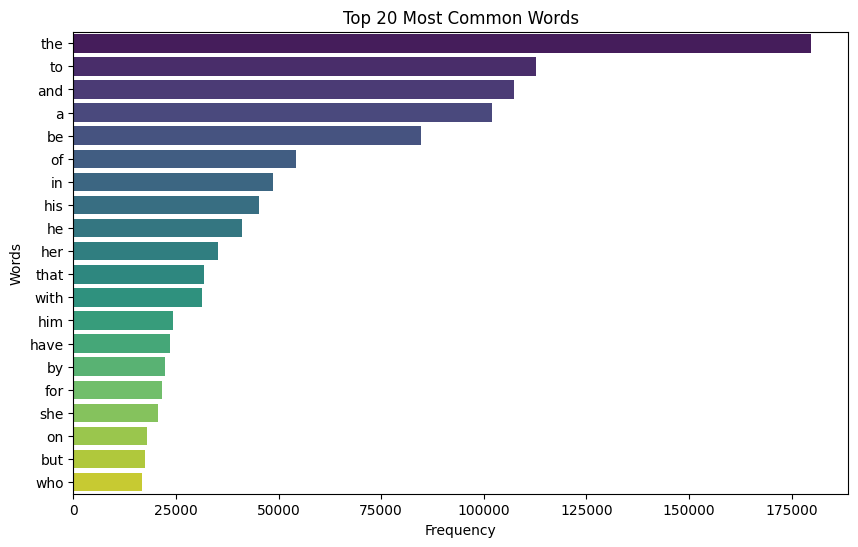

In [ ]:
# Flatten the list of tokens and count
all_words = [word for tokens in data['words'] for word in tokens]
word_counts = Counter(all_words)

# Most common words
most_common_words = word_counts.most_common(20)

# Plotting the word frequency
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[count for word, count in most_common_words], y=[word for word, count in most_common_words], palette='viridis')
    plt.title('Top 20 Most Common Words')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

## Generating and Analyzing Bi-grams and Tri-grams

In [ ]:
# Function to generate and count ngrams
def generate_ngrams(words, n):
    ngrams_list = ngrams(words, n)
    ngrams_counts = Counter(ngrams_list)
    return ngrams_counts

# Generating bi-grams (2-grams) and tri-grams (3-grams)
data['Bigrams'] = data['words'].apply(lambda x: generate_ngrams(x, 2))
data['Trigrams'] = data['words'].apply(lambda x: generate_ngrams(x, 3))

data.head()

,title,from,genre,director,plot,title_plot,word_count,words,Bigrams,Trigrams
0,ela cheppanu,telugu,romance,ramana,sekhar tarun be a graduate from iim and work a...,ela cheppanu sekhar tarun be a graduate from i...,156,"[ela, cheppanu, sekhar, tarun, be, a, graduate...","{('ela', 'cheppanu'): 1, ('cheppanu', 'sekhar'...","{('ela', 'cheppanu', 'sekhar'): 1, ('cheppanu'..."
1,a nightmare on elm street,american,horror,samuel bayer,kris fowles katie cassidy go to the springwood...,a nightmare on elm street kris fowles katie ca...,663,"[a, nightmare, on, elm, street, kris, fowles, ...","{('a', 'nightmare'): 1, ('nightmare', 'on'): 1...","{('a', 'nightmare', 'on'): 1, ('nightmare', 'o..."
2,american gothic,american,horror,john hough,cynthia be traumatize by the death of her baby...,american gothic cynthia be traumatize by the d...,746,"[american, gothic, cynthia, be, traumatize, by...","{('american', 'gothic'): 1, ('gothic', 'cynthi...","{('american', 'gothic', 'cynthia'): 1, ('gothi..."
3,gang,bollywood,crime,mazhar khan,four friend gangu jackie shroff abdul nana pat...,gang four friend gangu jackie shroff abdul nan...,388,"[gang, four, friend, gangu, jackie, shroff, ab...","{('gang', 'four'): 1, ('four', 'friend'): 1, (...","{('gang', 'four', 'friend'): 1, ('four', 'frie..."
4,intimate relation,british,drama,charles frank,crisis in a middleclass family when the son fa...,intimate relation crisis in a middleclass fami...,38,"[intimate, relation, crisis, in, a, middleclas...","{('intimate', 'relation'): 1, ('relation', 'cr...","{('intimate', 'relation', 'crisis'): 1, ('rela..."


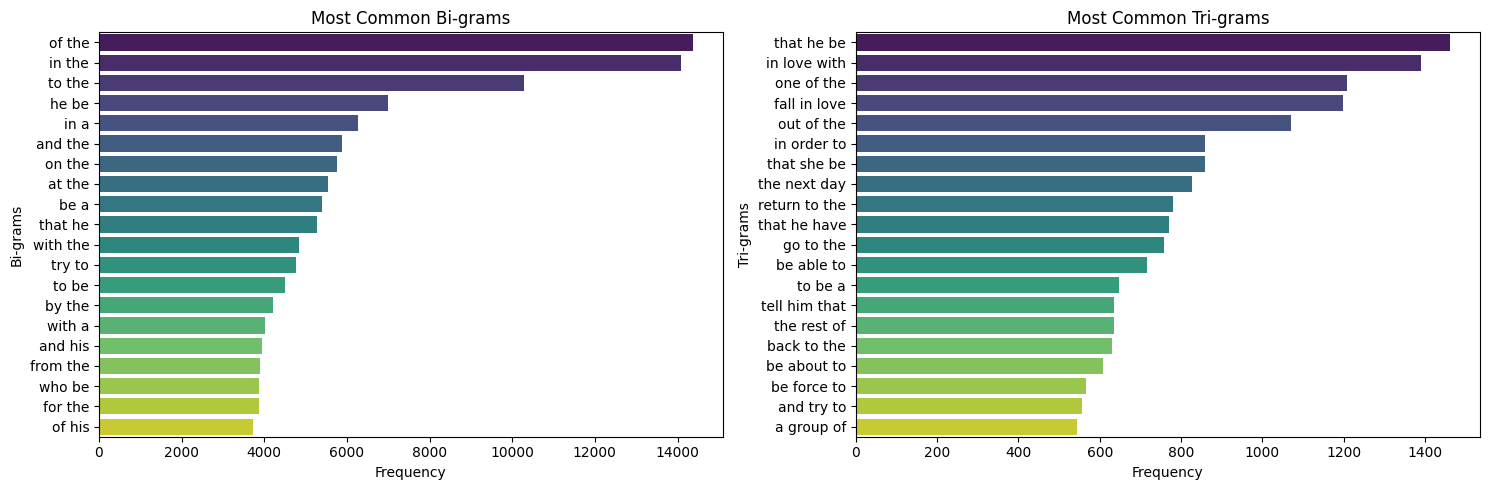

In [ ]:
# Initialize counters for b-igrams and tri-grams
bigram_counts = Counter()
trigram_counts = Counter()

# Sum the counts
for bigram_counter in data['Bigrams']:
    bigram_counts.update(bigram_counter)

for trigram_counter in data['Trigrams']:
    trigram_counts.update(trigram_counter)

# Most common bi-grams and tri-grams
most_common_bigrams = bigram_counts.most_common(20)
most_common_trigrams = trigram_counts.most_common(20)

# Plotting the most common bi-grams and tri-grams
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Bigrams
    sns.barplot(x=[count for bigram, count in most_common_bigrams], y=[' '.join(bigram) for bigram, count in most_common_bigrams], ax=axes[0], palette='viridis')
    axes[0].set_title('Most Common Bi-grams')
    axes[0].set_xlabel('Frequency')
    axes[0].set_ylabel('Bi-grams')

    # Trigrams
    sns.barplot(x=[count for trigram, count in most_common_trigrams], y=[' '.join(trigram) for trigram, count in most_common_trigrams], ax=axes[1], palette='viridis')
    axes[1].set_title('Most Common Tri-grams')
    axes[1].set_xlabel('Frequency')
    axes[1].set_ylabel('Tri-grams')

    plt.tight_layout()
    plt.show()

### Word Cloud

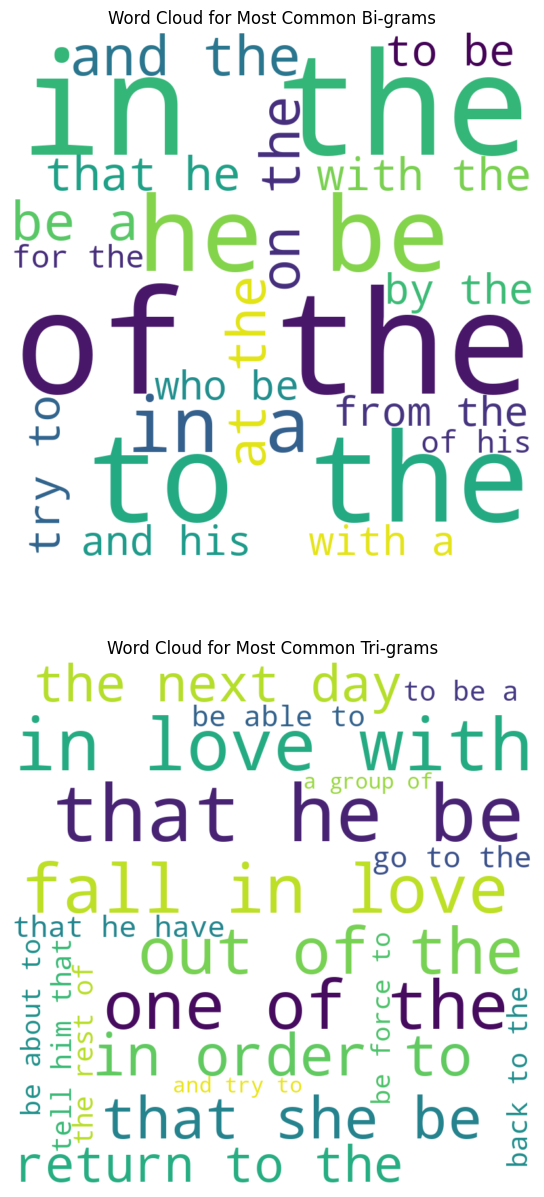

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    fig, axes = plt.subplots(2, 1, figsize=(15, 15))

    # Bi-grams
    word_freq = { ' '.join(k): v for k, v in dict(most_common_bigrams).items() }
    wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(word_freq)
    axes[0].imshow(wordcloud, interpolation='bilinear')
    axes[0].set_title('Word Cloud for Most Common Bi-grams')
    axes[0].axis('off')

    # Tri-grams
    word_freq = { ' '.join(k): v for k, v in dict(most_common_trigrams).items() }
    wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(word_freq)
    axes[1].imshow(wordcloud, interpolation='bilinear')
    axes[1].set_title('Word Cloud for Most Common Tri-grams')
    axes[1].axis('off')

    plt.show()

### Bi-Grams and Tri-grams by Genre

In [ ]:
# Function to aggregate and count n-grams for each genre
def aggregate_ngrams_by_genre(data, n):
    ngram_counts_by_genre = {}
    for genre in sorted(data['genre'].unique()):
        # Filter words for the specific genre
        genre_data = data[data['genre'] == genre]['words']

        # Flatten the genre_data list
        all_filtered_words_genre = [token for sublist in genre_data for token in sublist]

        # Generating and counting ngrams
        ngram_counts = generate_ngrams(all_filtered_words_genre, n)

        # Most common ngrams
        ngram_counts_by_genre[genre] = ngram_counts.most_common(10)

    return ngram_counts_by_genre

# Bi-grams and tri-grams for each genre
bigrams_by_genre = aggregate_ngrams_by_genre(data, 2)
trigrams_by_genre = aggregate_ngrams_by_genre(data, 3)

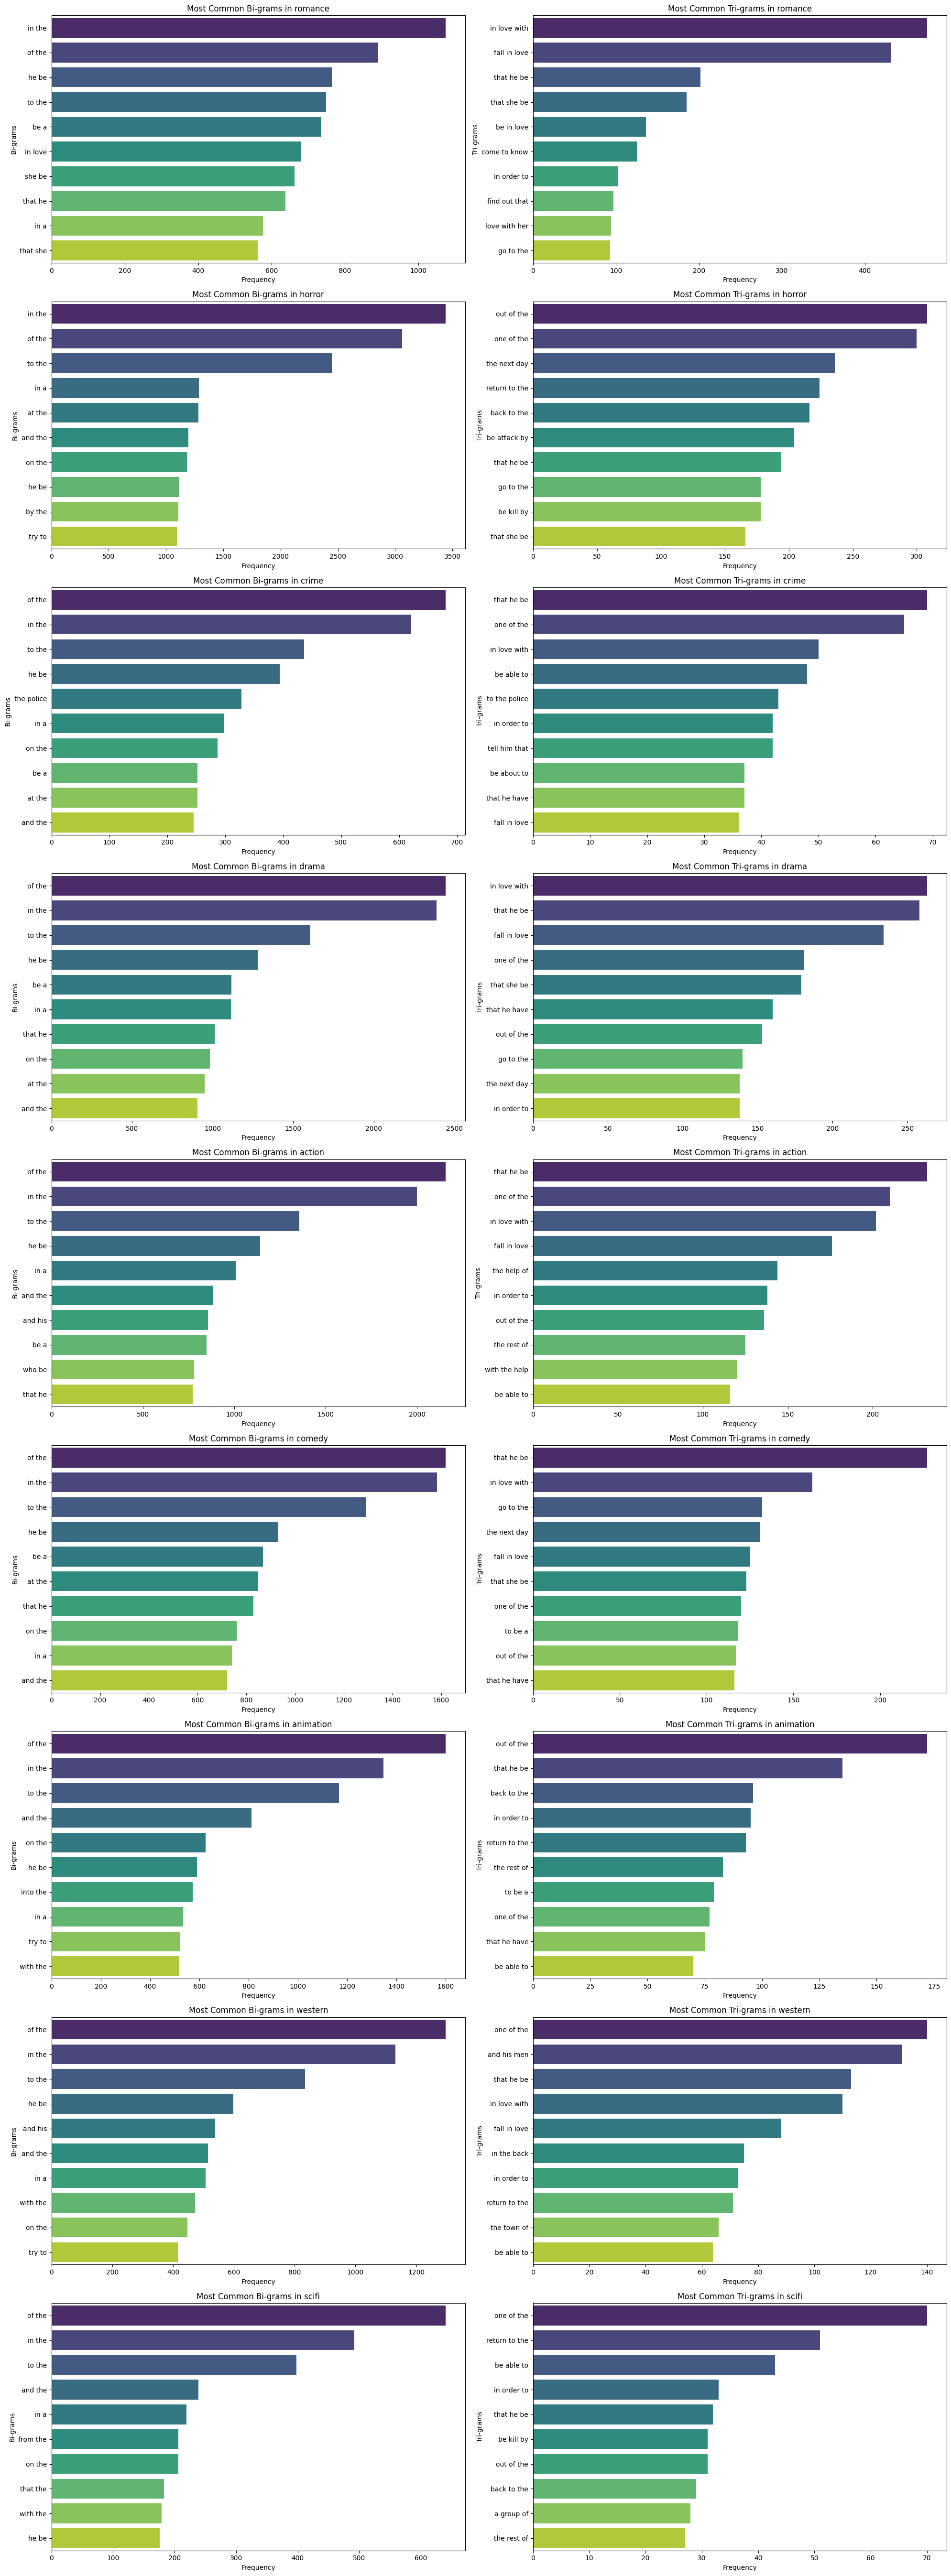

In [ ]:
# Plotting the most common bi-grams and tri-grams
def plot_ngrams_by_genre(genres, bigrams_by_genre, trigrams_by_genre):

    num_genres = len(genres)

    fig, axes = plt.subplots(num_genres, 2, figsize=(20, num_genres * 6))  # 2 columns: one for bi-grams, one for tri-grams

    for idx, genre in enumerate(genres):
        most_common_bigrams = bigrams_by_genre[genre]
        most_common_trigrams = trigrams_by_genre[genre]

        # Plotting bigrams
        sns.barplot(
            x=[count for ngram, count in most_common_bigrams],
            y=[' '.join(ngram) for ngram, count in most_common_bigrams],
            ax=axes[idx, 0],
            palette='viridis'
        )
        axes[idx, 0].set_title(f'Most Common Bi-grams in {genre}')
        axes[idx, 0].set_xlabel('Frequency')
        axes[idx, 0].set_ylabel('Bi-grams')

        # Plotting trigrams
        sns.barplot(
            x=[count for ngram, count in most_common_trigrams],
            y=[' '.join(ngram) for ngram, count in most_common_trigrams],
            ax=axes[idx, 1],
            palette='viridis'
        )
        axes[idx, 1].set_title(f'Most Common Tri-grams in {genre}')
        axes[idx, 1].set_xlabel('Frequency')
        axes[idx, 1].set_ylabel('Tri-grams')

    plt.tight_layout()
    plt.show()


genres = data['genre'].unique()
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    plot_ngrams_by_genre(genres, bigrams_by_genre, trigrams_by_genre)